In [64]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from skimage import morphology, measure
from skimage.filters import threshold_otsu
from scipy.ndimage import distance_transform_edt

In [65]:
def show_image(image, title='Image'):
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

# 1. Зерна

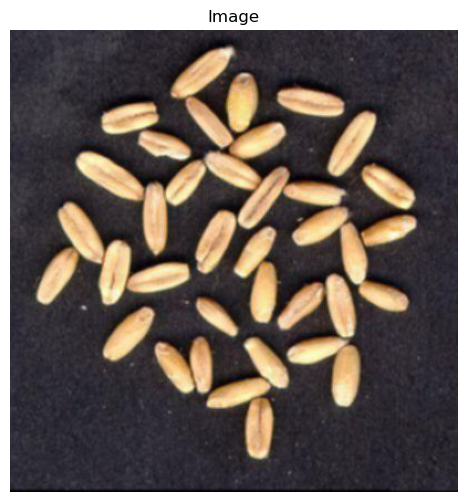

In [66]:
image = io.imread('sample10.jpg')
show_image(image)

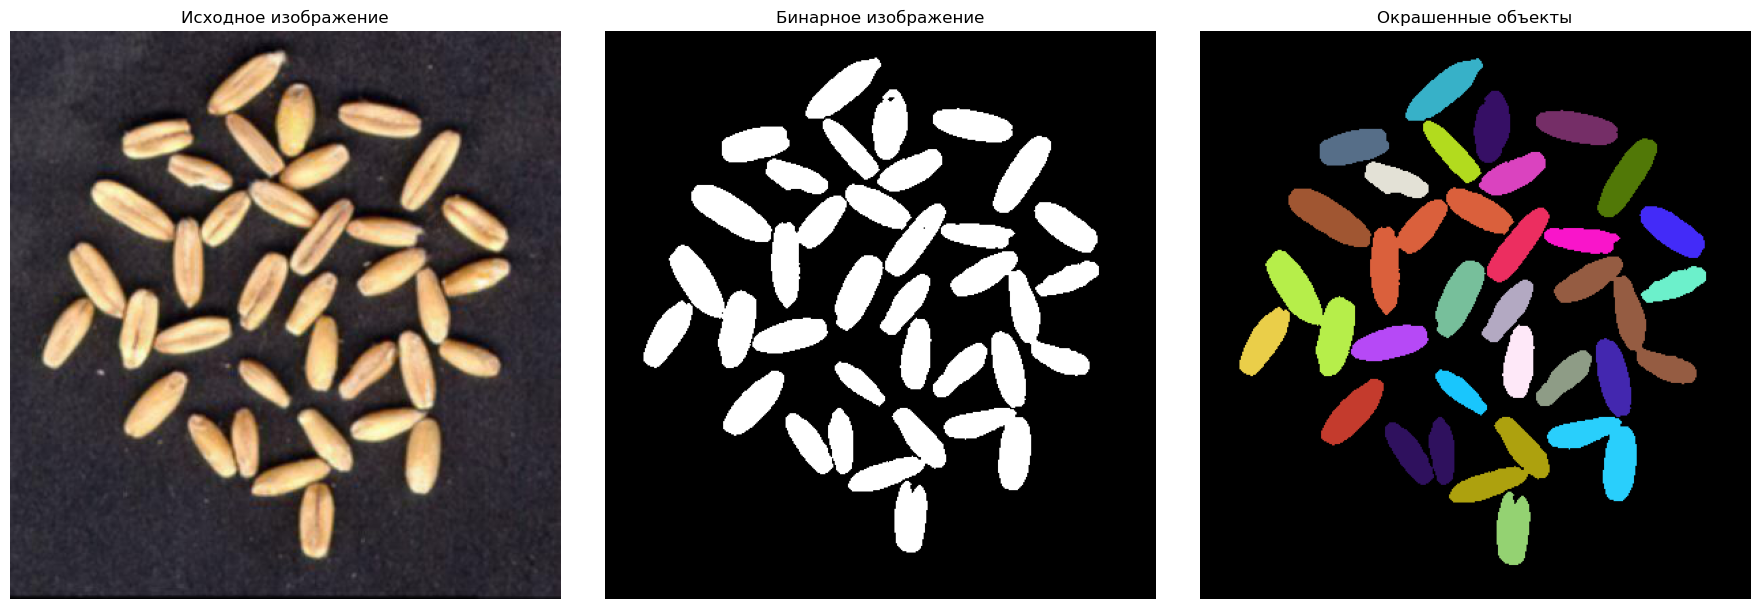

Количество зерен: 29


In [67]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Применение порогового преобразования (Otsu)
_, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Удаление шумов и отделение объектов (морфологические операции)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
binary_cleaned = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)

# Устранение касания зерен с краями
binary_cleaned = cv2.copyMakeBorder(binary_cleaned, 5, 5, 5, 5, cv2.BORDER_CONSTANT, value=0)

# Нахождение контуров объектов
contours, _ = cv2.findContours(binary_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Создание меток объектов
labeled_image = np.zeros_like(gray, dtype=np.int32)
for i, contour in enumerate(contours):
    cv2.drawContours(labeled_image, [contour], -1, i + 1, thickness=-1)  # Метка объектов

# Подготовка для окрашивания: Кластеризация (KMeans) для уникальных цветов
num_objects = len(contours)
labeled_flat = labeled_image.flatten()
unique_labels = np.unique(labeled_flat[labeled_flat > 0])  # Исключить фон (0)

# Создание цветовой карты
colors = np.random.randint(0, 255, size=(num_objects + 1, 3), dtype=np.uint8)
colored_image = np.zeros((*labeled_image.shape, 3), dtype=np.uint8)
for label in unique_labels:
    colored_image[labeled_image == label] = colors[label]

# Отображение результатов
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(image_rgb)
axes[0].set_title("Исходное изображение")
axes[1].imshow(binary_cleaned, cmap="gray")
axes[1].set_title("Бинарное изображение")
axes[2].imshow(colored_image)
axes[2].set_title("Окрашенные объекты")
for ax in axes:
    ax.axis("off")
plt.tight_layout()
plt.show()

# Подсчет количества зерен
print(f"Количество зерен: {num_objects}")


# 2. Нитка

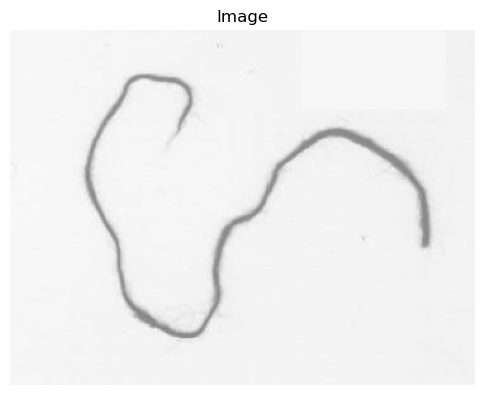

In [68]:
image = io.imread('sample29_cut.jpg')
image_bgr = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
show_image(image_bgr)

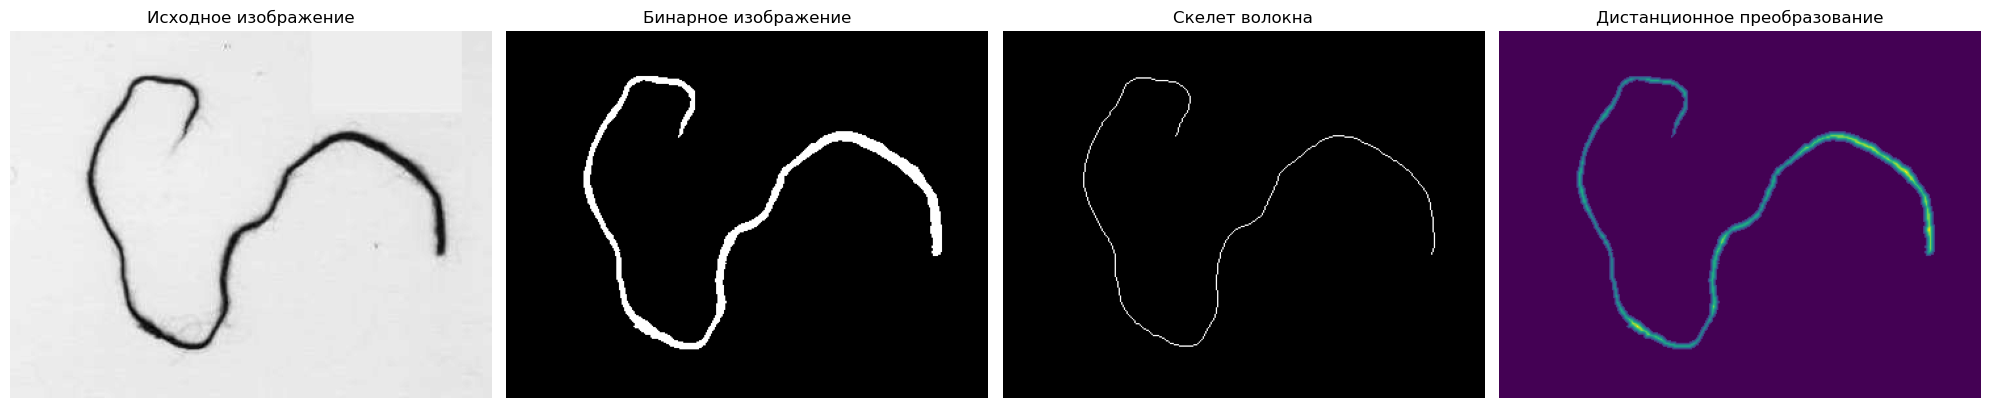

Длина волокна: 611 пикселей
Средняя ширина волокна: 5.81 пикселей


In [69]:
# Преобразование в бинарное изображение (пороговое значение Otsu)
_, binary_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Удаление мелких объектов (если есть шумы)
binary_cleaned = morphology.remove_small_objects(binary_image.astype(bool), 50)

# Скелетизация (нахождение центральной линии волокна)
skeleton = morphology.skeletonize(binary_cleaned)

# Вычисление длины волокна по скелету
fiber_length = np.sum(skeleton)  # Количество пикселей в скелете

# Дистанционное преобразование для определения ширины волокна
distance_transform = distance_transform_edt(binary_cleaned)
fiber_widths = distance_transform[skeleton] * 2  # Умножение на 2 для реальной ширины
average_width = np.mean(fiber_widths)

# Отображение результатов
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(image, cmap="gray")
axes[0].set_title("Исходное изображение")
axes[1].imshow(binary_cleaned, cmap="gray")
axes[1].set_title("Бинарное изображение")
axes[2].imshow(skeleton, cmap="gray")
axes[2].set_title("Скелет волокна")
axes[3].imshow(distance_transform, cmap="viridis")
axes[3].set_title("Дистанционное преобразование")
for ax in axes:
    ax.axis("off")
plt.tight_layout()
plt.show()

# Вывод длины и средней ширины волокна
print(f"Длина волокна: {fiber_length} пикселей")
print(f"Средняя ширина волокна: {average_width:.2f} пикселей")